### Workbook by Misha Salkinder
### Home Credit Default Risk Kaggle Competition
### GXBoost

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.utils import resample

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

sns.set()

In [3]:
df_read = pd.DataFrame()
for chunk in pd.read_csv('application_train_merged_FINAL.csv', index_col=None, chunksize=10000, low_memory=False):
    df_read = pd.concat([df_read,chunk])
    
df_read.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,prev_prev_app_late_min_count,prev_prev_app_late_min_mean,prev_prev_app_late_min_max,prev_prev_app_late_min_min,prev_prev_app_late_min_sum,prev_prev_app_late_sum_count,prev_prev_app_late_sum_mean,prev_prev_app_late_sum_max,prev_prev_app_late_sum_min,prev_prev_app_late_sum_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,19.0,0.000000,0.0,0.0,0.0,19.0,0.000000,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,25.0,0.000000,0.0,0.0,0.0,25.0,0.000000,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,3.0,0.000000,0.0,0.0,0.0,3.0,0.000000,0.0,0.0,0.0
3,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,66.0,0.151515,1.0,0.0,10.0,66.0,2.757576,10.0,0.0,182.0
4,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,35.0,0.000000,0.0,0.0,0.0,35.0,0.314286,1.0,0.0,11.0


In [4]:
#undersampling as our current ratio of 1 to 0 is only .9. 

# Separate majority and minority classes
df_majority = df_read[df_read.TARGET==0]
df_minority = df_read[df_read.TARGET==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=20000,     # to match minority class
                                 random_state=42) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.TARGET.value_counts()

0    20000
1    19191
Name: TARGET, dtype: int64

In [5]:
df = df_downsampled

In [6]:
# Finding categorical variables
cols = df.columns

num_cols = df._get_numeric_data().columns

list(set(cols) - set(num_cols))

['FLAG_OWN_REALTY',
 'ORGANIZATION_TYPE',
 'CODE_GENDER',
 'NAME_INCOME_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'NAME_CONTRACT_TYPE',
 'FLAG_OWN_CAR',
 'NAME_FAMILY_STATUS',
 'NAME_TYPE_SUITE',
 'NAME_EDUCATION_TYPE',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE']

In [7]:
# Transforming categorical variable into Dummies

df = df.join(pd.get_dummies(df.NAME_HOUSING_TYPE)).drop("NAME_HOUSING_TYPE", axis=1)
df = df.join(pd.get_dummies(df.NAME_FAMILY_STATUS)).drop("NAME_FAMILY_STATUS", axis=1)
df = df.join(pd.get_dummies(df.WEEKDAY_APPR_PROCESS_START)).drop("WEEKDAY_APPR_PROCESS_START", axis=1)
df = df.join(pd.get_dummies(df.FLAG_OWN_REALTY)).drop("FLAG_OWN_REALTY", axis=1)
df = df.join(pd.get_dummies(df.OCCUPATION_TYPE)).drop("OCCUPATION_TYPE", axis=1)
df = df.join(pd.get_dummies(df.NAME_TYPE_SUITE)).drop("NAME_TYPE_SUITE", axis=1)
df = df.join(pd.get_dummies(df.CODE_GENDER)).drop("CODE_GENDER", axis=1)
df = df.join(pd.get_dummies(df.NAME_INCOME_TYPE)).drop("NAME_INCOME_TYPE", axis=1)
df = df.join(pd.get_dummies(df.NAME_EDUCATION_TYPE)).drop("NAME_EDUCATION_TYPE", axis=1)
df = df.join(pd.get_dummies(df.ORGANIZATION_TYPE)).drop("ORGANIZATION_TYPE", axis=1)
df = df.join(pd.get_dummies(df.NAME_CONTRACT_TYPE)).drop("NAME_CONTRACT_TYPE", axis=1)
df = df.join(pd.get_dummies(df.FLAG_OWN_CAR), lsuffix='_x', rsuffix='_car').drop("FLAG_OWN_CAR", axis=1)

df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,Transport: type 1,Transport: type 2,Transport: type 3,Transport: type 4,University,XNA,Cash loans,Revolving loans,N_car,Y_car
7010,110121,0,0,405000.0,450000.0,48595.5,450000.0,0.014520,-14730,-2419,...,0,0,0,0,0,0,1,0,1,0
16124,123436,0,0,112500.0,337500.0,12852.0,337500.0,0.018209,-22373,365243,...,0,0,0,0,0,1,1,0,0,1
45173,165296,0,0,157500.0,622413.0,30073.5,495000.0,0.009657,-9312,-1095,...,0,0,0,0,0,0,1,0,1,0
24165,134954,0,0,193500.0,315000.0,15750.0,315000.0,0.003122,-20306,-3027,...,0,0,0,0,0,0,0,1,1,0
209416,402826,0,0,157500.0,95940.0,10201.5,90000.0,0.010006,-20094,-714,...,0,0,0,0,0,0,1,0,0,1


In [8]:
# Some simple new features (percentages)
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

In [10]:
df.to_csv('train_for_submission.csv',index=False)

In [8]:
X = df.drop(['TARGET', 'SK_ID_CURR'], axis=1) #Dependent Variable
X.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,XNA,Cash loans,Revolving loans,N_car,Y_car,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
7010,0,405000.0,450000.0,48595.5,450000.0,0.014520,-14730,-2419,-61.0,-5955,...,0,1,0,1,0,0.164223,0.900000,202500.0,0.119989,0.107990
16124,0,112500.0,337500.0,12852.0,337500.0,0.018209,-22373,365243,-1239.0,-4899,...,1,1,0,0,1,-16.325169,0.333333,56250.0,0.114240,0.038080
45173,0,157500.0,622413.0,30073.5,495000.0,0.009657,-9312,-1095,-3410.0,-1965,...,0,1,0,1,0,0.117590,0.253047,78750.0,0.190943,0.048318
24165,0,193500.0,315000.0,15750.0,315000.0,0.003122,-20306,-3027,-1296.0,-1619,...,0,0,1,1,0,0.149069,0.614286,96750.0,0.081395,0.050000
209416,0,157500.0,95940.0,10201.5,90000.0,0.010006,-20094,-714,-4770.0,-3611,...,0,1,0,0,1,0.035533,1.641651,78750.0,0.064771,0.106332


In [9]:
y = df.TARGET #Target variable
y.head()

7010      0
16124     0
45173     0
24165     0
209416    0
Name: TARGET, dtype: int64

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
XGB = XGBClassifier(objective ='binary:logistic')
XGB.fit(X_train,y_train)
y_pred2 = XGB.predict(X_test)
roc_auc_score(y_test, y_pred2)

0.7033446915830239

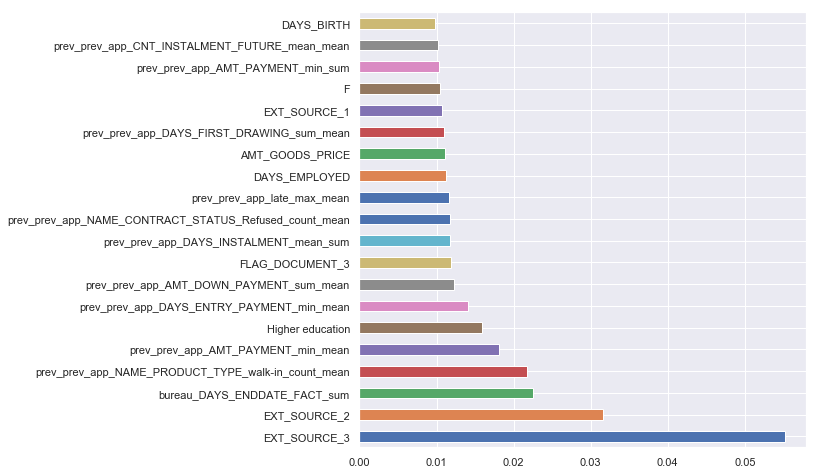

In [13]:
plt.figure(figsize = (8, 8))
feat_importances = pd.Series(XGB.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [14]:
# Parameter Tuning using Scikit-Optimize

# Classifier
bayes_cv_tuner = BayesSearchCV(
    estimator = XGBClassifier(
        n_jobs = 1,
        objective = 'binary:logistic',
        eval_metric = 'auc',
        silent=1,
        tree_method='approx'
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 10),
        'max_depth': (0, 50),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-9, 1000, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'gamma': (1e-9, 0.5, 'log-uniform'),
        'min_child_weight': (0, 5),
        'n_estimators': (50, 100),
        'scale_pos_weight': (1e-6, 500, 'log-uniform')
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=4,
        shuffle=True,
        random_state=42
    ),
    n_jobs = 3,
    n_iter = 10,   
    verbose = 0,
    refit = True,
    random_state = 42
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    ))

In [15]:
result = bayes_cv_tuner.fit(X.values, y.values, callback=status_print)

Model #1
Best ROC-AUC: 0.7615
Best params: {'colsample_bylevel': 0.4160029192647807, 'colsample_bytree': 0.7304484857455519, 'gamma': 0.13031389926541354, 'learning_rate': 0.042815319280763466, 'max_delta_step': 13, 'max_depth': 21, 'min_child_weight': 2, 'n_estimators': 87, 'reg_alpha': 5.497557739289786e-07, 'reg_lambda': 0.05936070635912049, 'scale_pos_weight': 0.060830282487222144, 'subsample': 0.13556548021189216}

Model #2
Best ROC-AUC: 0.7695
Best params: {'colsample_bylevel': 0.8390144719977516, 'colsample_bytree': 0.8844821246070537, 'gamma': 4.358684608480795e-07, 'learning_rate': 0.7988179462781242, 'max_delta_step': 17, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 68, 'reg_alpha': 0.0005266983003701547, 'reg_lambda': 276.5424475574225, 'scale_pos_weight': 0.3016410771843142, 'subsample': 0.9923710598637134}

Model #3
Best ROC-AUC: 0.7695
Best params: {'colsample_bylevel': 0.8390144719977516, 'colsample_bytree': 0.8844821246070537, 'gamma': 4.358684608480795e-07, '

In [30]:
# kfold cross validation of the XGBoost model
from sklearn.model_selection import KFold

# XGB parameters found by Bayesian optimization above
model = XGBClassifier(
            objective ='binary:logistic',
            colsample_bylevel= 0.8390144719977516, 
            colsample_bytree= 0.8844821246070537, 
            gamma= 4.358684608480795e-07, 
            learning_rate= 0.7988179462781242, 
            max_delta_step= 17, 
            max_depth=3, 
            min_child_weight= 1, 
            n_estimators= 68, 
            reg_alpha= 0.0005266983003701547, 
            reg_lambda= 276.5424475574225, 
            scale_pos_weight= 0.3016410771843142, 
            subsample= 0.9923710598637134)

kfold = StratifiedKFold(n_splits=10, random_state=42)
results = cross_val_score(model, X, y, cv=kfold, scoring='roc_auc')
print("roc_auc:", "%.3f" % results.mean(), "std:", "%.3f" % results.std())    

roc_auc: 0.774 std 0.005


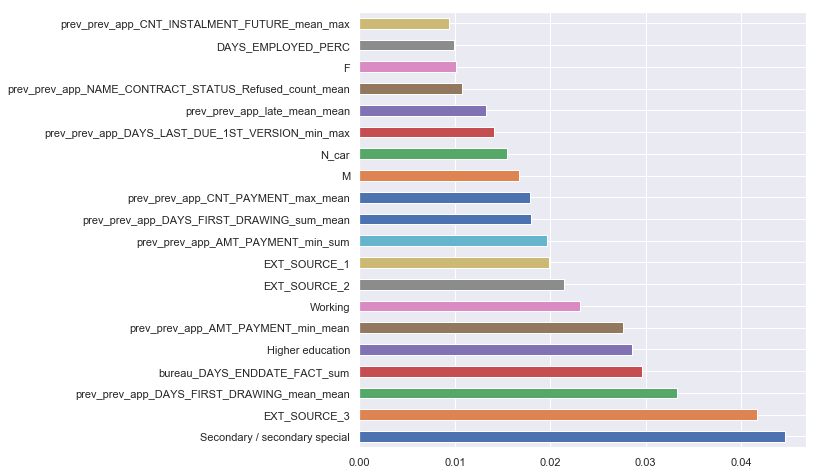

In [31]:
model.fit(X,y)
plt.figure(figsize = (8, 8))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [38]:
df_read['NAME_EDUCATION_TYPE'].unique()

array(['Secondary / secondary special', 'Higher education',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)